In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
sns.set_style('darkgrid')

In [2]:
df = pd.read_csv('Dataset\medical.csv')

In [3]:
pd.concat([df.head(), df.tail()])

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500
1337,61,female,29.070,0,yes,northwest,29141.36030


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [5]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


### EDA

In [31]:
def show_box_hsit(df, col):
    sns.set_style('darkgrid')
    fig, ax = plt.subplots(2,1, figsize=(12,5), gridspec_kw={'height_ratios' : [1,5]})
    ax[0].set(title=f'BoxPlot of {col}')
    sns.boxplot(data=df, x=col, orient='h', ax=ax[0])
    ax[1].set(title=f'Distribution of {col}')
    sns.histplot(data=df, x=col, bins=round(df[col].max()-df[col].min()+1), ax=ax[1])
    plt.tight_layout()
    sns.despine()
    plt.show()

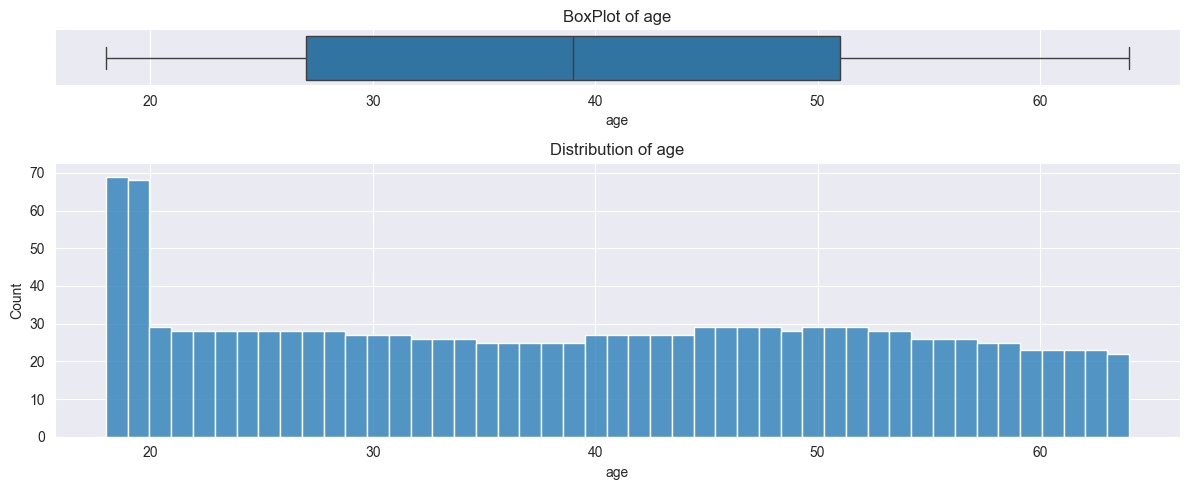

In [32]:
show_box_hsit(df, 'age')

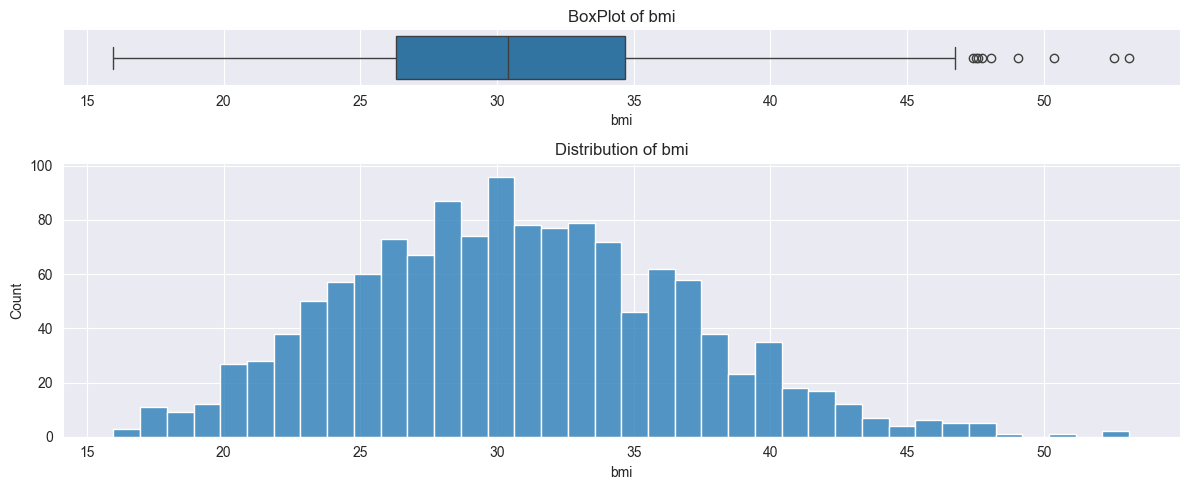

In [33]:
show_box_hsit(df, 'bmi')

In [41]:
def show_scatterplot(df, x, y, hue):
    plt.figure(figsize=(10,3))
    sns.scatterplot(data=df, x=x, y=y, hue=hue)
    plt.show()

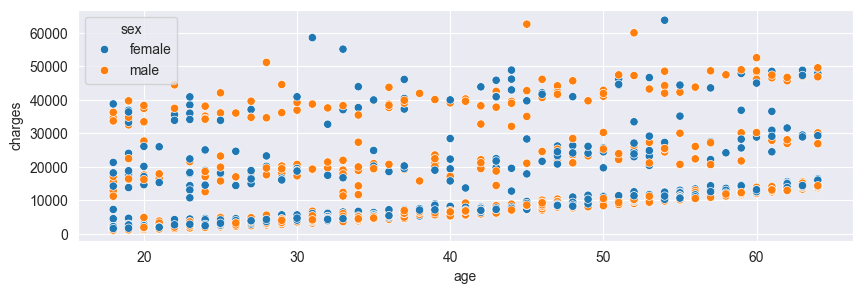

In [42]:
show_scatterplot(df, x='age', y='charges', hue='sex')

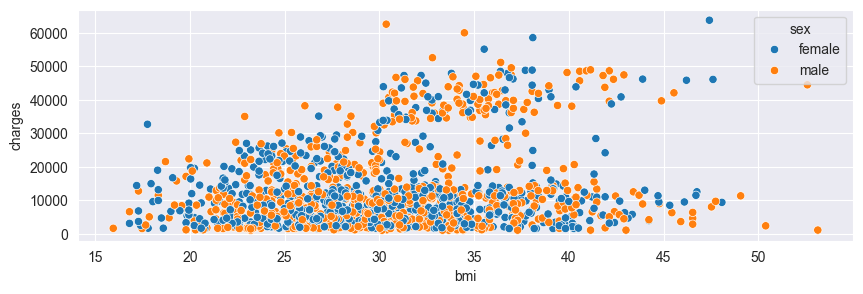

In [43]:
show_scatterplot(df, x='bmi', y='charges', hue='sex')

<Figure size 1500x700 with 0 Axes>

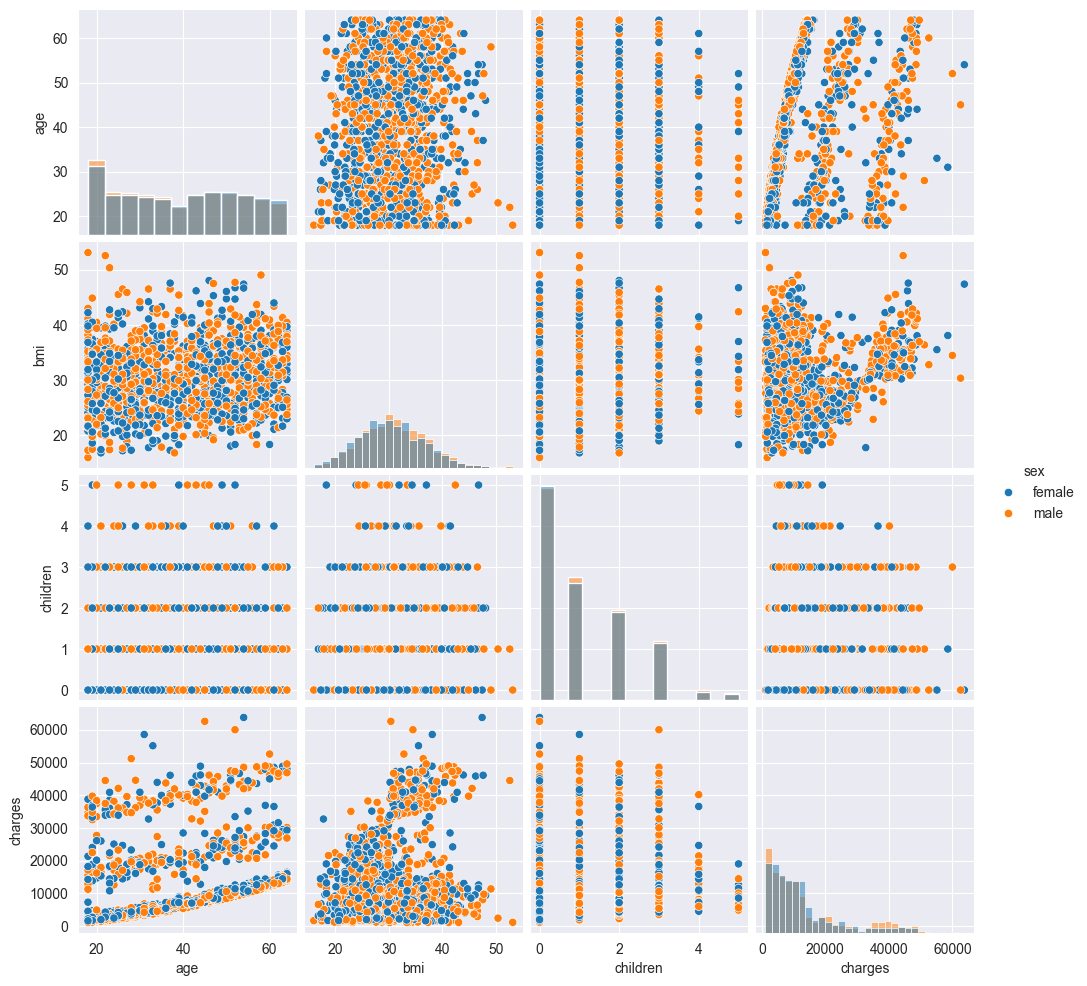

In [45]:
plt.figure(figsize=(15, 7))
sns.pairplot(data=df, hue='sex', diag_kind='hist')